Решение задачи предсказания преступности на душу населения
https://www.kaggle.com/arslanali4343/real-estate-dataset/tasks

# **Имортируем библиотеки**

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('data.csv')
df = df.fillna(0)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


# **Анализ датасета**

Распределения различных признаков

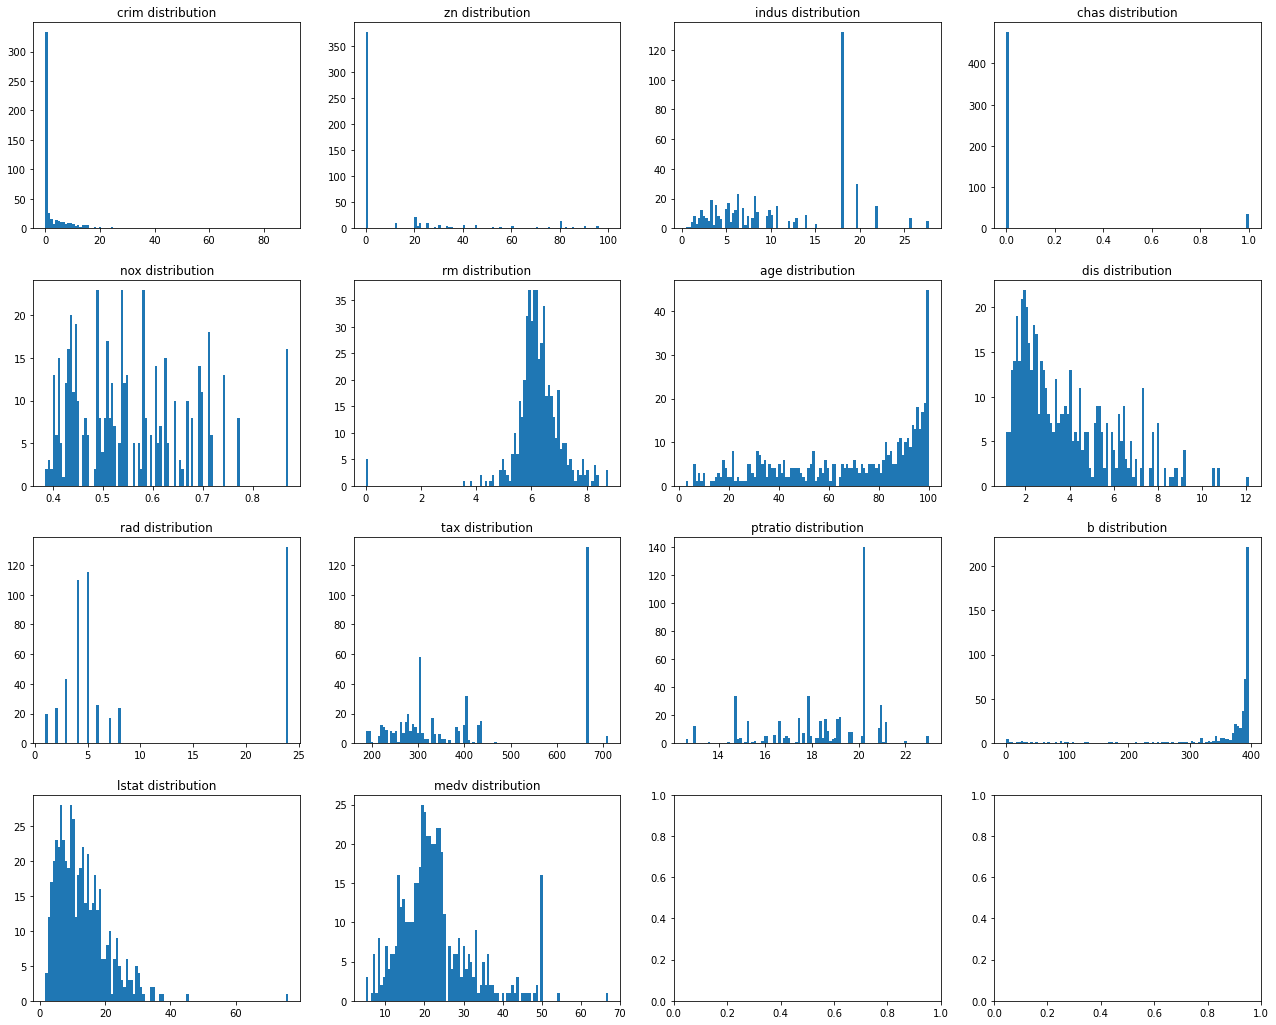

In [4]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(22,18))
fig.subplots_adjust(hspace=0.25)

for ax, col in zip(axes.flatten(), df.columns):
    ax.hist(df[[col]].values, bins=100)
    ax.set(title=str(col).lower() + " distribution")

Вычисление корреляционной матрицы

<AxesSubplot:>

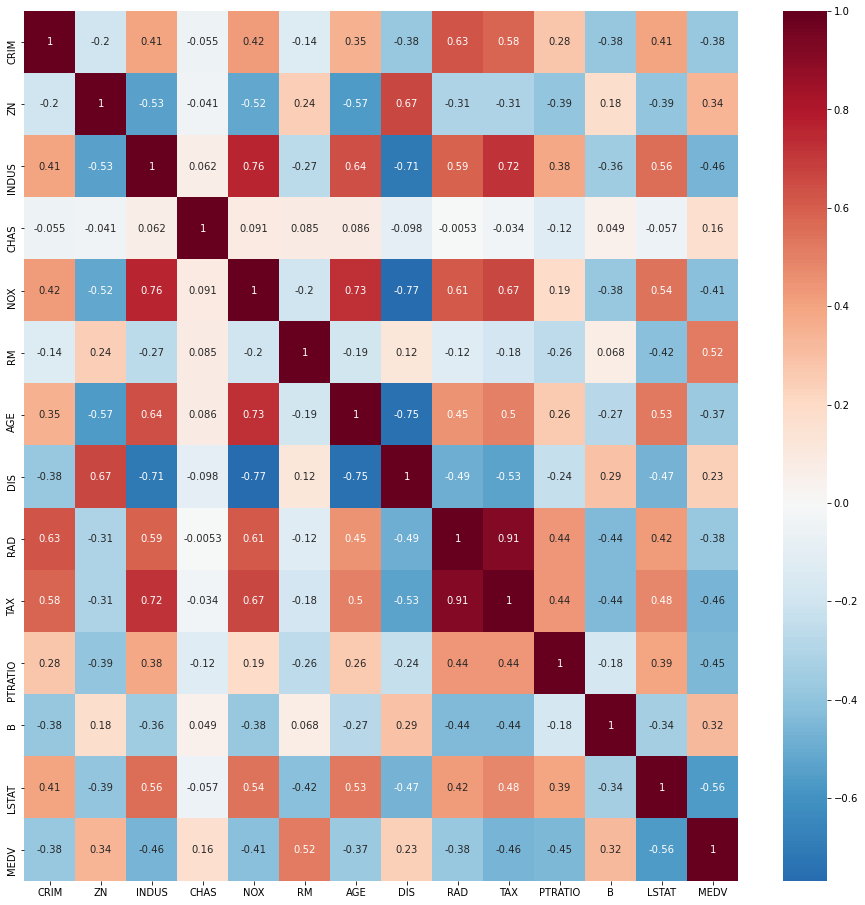

In [5]:
s_fig, s_ax = plt.subplots(figsize=(16, 16))

cols = df.columns
sns.heatmap(df[cols].corr(), ax=s_ax, cmap='RdBu_r', annot=True, center=0.0)

# Линейные модели

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(["CRIM"], axis=1))
y_scaled = scaler.fit_transform(df[["CRIM"]])

In [7]:
clf_linear = linear_model.LinearRegression()
pred_linear = cross_val_predict(clf_linear, X_scaled, y_scaled, cv=5)

scores_linear = cross_val_score(clf_linear, X_scaled, y_scaled, cv=5, scoring="neg_mean_squared_error")
mse_linear = mean_squared_error(y_scaled, pred_linear)
print (f"linear cross_val_scores: {scores_linear}")
print (f"linear mse_score:        {mse_linear:.10}")
print(np.mean(scores_linear))

linear cross_val_scores: [-0.05571769 -0.13407522 -0.06879937 -1.88470829 -1.35419064]
linear mse_score:        0.6982383967
-0.6994982412418957


In [8]:
clf_ridge = linear_model.Ridge(alpha = 100)
pred_ridge = cross_val_predict(clf_ridge, X_scaled, y_scaled, cv=5)

scores_ridge = cross_val_score(clf_ridge, X_scaled, y_scaled, cv=5, scoring="neg_mean_squared_error")
mse_ridge = mean_squared_error(y_scaled, pred_ridge)
print (f"ridge cross_val_scores: {scores_ridge}")
print (f"ridge mse_score:        {mse_ridge:.10}")
print(np.mean(scores_ridge))

ridge cross_val_scores: [-0.03558523 -0.12261051 -0.02453801 -1.97622543 -1.30578941]
ridge mse_score:        0.6916632912
-0.6929497187743091


In [9]:
clf_sgd = linear_model.SGDRegressor()
pred_sgd = cross_val_predict(clf_sgd, X_scaled, y_scaled, cv=5)

scores_sgd = cross_val_score(clf_sgd, X_scaled, y_scaled, cv=5, scoring="neg_mean_squared_error")
mse_sgd = mean_squared_error(y_scaled, pred_sgd)
print (f"sgd cross_val_scores: {scores_sgd}")
print (f"sgd mse_score:        {mse_sgd:.10}")
print(np.mean(scores_sgd))

sgd cross_val_scores: [-0.05201208 -0.07959901 -0.03980527 -1.9120239  -1.37859093]
sgd mse_score:        0.690673013
-0.692406237609837


# Нейронная сеть

Обучим нейронную сеть

In [10]:
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2)

In [12]:
class RegressionDataset(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data, device):
        self.X_data = X_data.to(device)
        self.y_data = y_data.to(device)
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [13]:
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), device)
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float(), device)

In [14]:
class RegressionNet(torch.nn.Module):
    def __init__(self, num_features):
        super(RegressionNet, self).__init__()
        self.fc1 = torch.nn.Linear(num_features, 3)
        self.act1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(3, 1)
        self.act2 = torch.nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        return x

In [15]:
EPOCHS = 1000
BATCH_SIZE = 16
LEARNING_RATE = 0.00001
NUM_FEATURES = X_train.shape[1]

In [16]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=1)

In [17]:
neural_network = RegressionNet(NUM_FEATURES)
neural_network.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(neural_network.parameters(), lr=LEARNING_RATE)

In [18]:
loss_stats = {'train': [], 'val': []}

In [19]:
for e in tqdm(range(1, EPOCHS+1)):
    train_epoch_loss = 0
    neural_network.train()
    for X_train_batch, y_train_batch in train_loader:
        optimizer.zero_grad()
        y_train_pred = neural_network(X_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
            
    with torch.no_grad():
        val_epoch_loss = 0
        neural_network.eval()
        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = neural_network(X_val_batch)          
            val_loss = criterion(y_val_pred, y_val_batch)
            val_epoch_loss += val_loss.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print('Epoch {:03}: | Train Loss: {:.5f} | Val Loss: {:.5f}'.format(e, train_epoch_loss/len(train_loader),
                                                                        val_epoch_loss/len(val_loader)))

Epoch 001: | Train Loss: 1.90605 | Val Loss: 1.43097
Epoch 002: | Train Loss: 1.90515 | Val Loss: 1.42799
Epoch 003: | Train Loss: 1.87319 | Val Loss: 1.42506
Epoch 004: | Train Loss: 1.86498 | Val Loss: 1.42211
Epoch 005: | Train Loss: 1.85931 | Val Loss: 1.41926
Epoch 006: | Train Loss: 1.85684 | Val Loss: 1.41635
Epoch 007: | Train Loss: 1.86459 | Val Loss: 1.41347
Epoch 008: | Train Loss: 1.85344 | Val Loss: 1.41067
Epoch 009: | Train Loss: 1.86828 | Val Loss: 1.40788
Epoch 010: | Train Loss: 1.85424 | Val Loss: 1.40493
Epoch 011: | Train Loss: 1.95714 | Val Loss: 1.40215
Epoch 012: | Train Loss: 1.84603 | Val Loss: 1.39938
Epoch 013: | Train Loss: 1.84209 | Val Loss: 1.39659
Epoch 014: | Train Loss: 1.94671 | Val Loss: 1.39383
Epoch 015: | Train Loss: 1.83746 | Val Loss: 1.39112
Epoch 016: | Train Loss: 1.83560 | Val Loss: 1.38844
Epoch 017: | Train Loss: 1.82910 | Val Loss: 1.38583
Epoch 018: | Train Loss: 1.83086 | Val Loss: 1.38319
Epoch 019: | Train Loss: 1.81846 | Val Loss: 1

Epoch 156: | Train Loss: 1.57273 | Val Loss: 1.12936
Epoch 157: | Train Loss: 1.57147 | Val Loss: 1.12815
Epoch 158: | Train Loss: 1.56818 | Val Loss: 1.12691
Epoch 159: | Train Loss: 1.57106 | Val Loss: 1.12569
Epoch 160: | Train Loss: 1.57058 | Val Loss: 1.12449
Epoch 161: | Train Loss: 1.59386 | Val Loss: 1.12328
Epoch 162: | Train Loss: 1.56444 | Val Loss: 1.12205
Epoch 163: | Train Loss: 1.56113 | Val Loss: 1.12087
Epoch 164: | Train Loss: 1.56384 | Val Loss: 1.11967
Epoch 165: | Train Loss: 1.55847 | Val Loss: 1.11847
Epoch 166: | Train Loss: 1.56662 | Val Loss: 1.11730
Epoch 167: | Train Loss: 1.56247 | Val Loss: 1.11608
Epoch 168: | Train Loss: 1.55578 | Val Loss: 1.11489
Epoch 169: | Train Loss: 1.57896 | Val Loss: 1.11373
Epoch 170: | Train Loss: 1.55691 | Val Loss: 1.11257
Epoch 171: | Train Loss: 1.55919 | Val Loss: 1.11142
Epoch 172: | Train Loss: 1.55107 | Val Loss: 1.11027
Epoch 173: | Train Loss: 1.55013 | Val Loss: 1.10912
Epoch 174: | Train Loss: 1.55296 | Val Loss: 1

Epoch 312: | Train Loss: 1.41088 | Val Loss: 0.98881
Epoch 313: | Train Loss: 1.40915 | Val Loss: 0.98811
Epoch 314: | Train Loss: 1.41134 | Val Loss: 0.98744
Epoch 315: | Train Loss: 1.40527 | Val Loss: 0.98671
Epoch 316: | Train Loss: 1.41124 | Val Loss: 0.98605
Epoch 317: | Train Loss: 1.40447 | Val Loss: 0.98533
Epoch 318: | Train Loss: 1.41008 | Val Loss: 0.98468
Epoch 319: | Train Loss: 1.40681 | Val Loss: 0.98401
Epoch 320: | Train Loss: 1.50858 | Val Loss: 0.98328
Epoch 321: | Train Loss: 1.40404 | Val Loss: 0.98265
Epoch 322: | Train Loss: 1.40570 | Val Loss: 0.98201
Epoch 323: | Train Loss: 1.39897 | Val Loss: 0.98130
Epoch 324: | Train Loss: 1.40124 | Val Loss: 0.98066
Epoch 325: | Train Loss: 1.39949 | Val Loss: 0.97996
Epoch 326: | Train Loss: 1.40070 | Val Loss: 0.97929
Epoch 327: | Train Loss: 1.39587 | Val Loss: 0.97867
Epoch 328: | Train Loss: 1.39780 | Val Loss: 0.97800
Epoch 329: | Train Loss: 1.42103 | Val Loss: 0.97736
Epoch 330: | Train Loss: 1.40129 | Val Loss: 0

Epoch 468: | Train Loss: 1.32367 | Val Loss: 0.89417
Epoch 469: | Train Loss: 1.30139 | Val Loss: 0.89364
Epoch 470: | Train Loss: 1.30060 | Val Loss: 0.89308
Epoch 471: | Train Loss: 1.30454 | Val Loss: 0.89250
Epoch 472: | Train Loss: 1.30169 | Val Loss: 0.89196
Epoch 473: | Train Loss: 1.30474 | Val Loss: 0.89145
Epoch 474: | Train Loss: 1.29780 | Val Loss: 0.89088
Epoch 475: | Train Loss: 1.40350 | Val Loss: 0.89030
Epoch 476: | Train Loss: 1.30677 | Val Loss: 0.88978
Epoch 477: | Train Loss: 1.30214 | Val Loss: 0.88922
Epoch 478: | Train Loss: 1.29642 | Val Loss: 0.88869
Epoch 479: | Train Loss: 1.29746 | Val Loss: 0.88814
Epoch 480: | Train Loss: 1.31986 | Val Loss: 0.88756
Epoch 481: | Train Loss: 1.29935 | Val Loss: 0.88703
Epoch 482: | Train Loss: 1.29390 | Val Loss: 0.88646
Epoch 483: | Train Loss: 1.29501 | Val Loss: 0.88594
Epoch 484: | Train Loss: 1.29220 | Val Loss: 0.88538
Epoch 485: | Train Loss: 1.29519 | Val Loss: 0.88483
Epoch 486: | Train Loss: 1.29605 | Val Loss: 0

Epoch 623: | Train Loss: 1.22181 | Val Loss: 0.81476
Epoch 624: | Train Loss: 1.21971 | Val Loss: 0.81434
Epoch 625: | Train Loss: 1.22119 | Val Loss: 0.81385
Epoch 626: | Train Loss: 1.22008 | Val Loss: 0.81335
Epoch 627: | Train Loss: 1.22088 | Val Loss: 0.81292
Epoch 628: | Train Loss: 1.22069 | Val Loss: 0.81244
Epoch 629: | Train Loss: 1.21680 | Val Loss: 0.81192
Epoch 630: | Train Loss: 1.21923 | Val Loss: 0.81147
Epoch 631: | Train Loss: 1.21946 | Val Loss: 0.81104
Epoch 632: | Train Loss: 1.21911 | Val Loss: 0.81055
Epoch 633: | Train Loss: 1.23981 | Val Loss: 0.81005
Epoch 634: | Train Loss: 1.21842 | Val Loss: 0.80963
Epoch 635: | Train Loss: 1.21586 | Val Loss: 0.80913
Epoch 636: | Train Loss: 1.21770 | Val Loss: 0.80868
Epoch 637: | Train Loss: 1.21497 | Val Loss: 0.80819
Epoch 638: | Train Loss: 1.21500 | Val Loss: 0.80771
Epoch 639: | Train Loss: 1.21473 | Val Loss: 0.80729
Epoch 640: | Train Loss: 1.21248 | Val Loss: 0.80677
Epoch 641: | Train Loss: 1.21255 | Val Loss: 0

Epoch 779: | Train Loss: 1.15517 | Val Loss: 0.74696
Epoch 780: | Train Loss: 1.15951 | Val Loss: 0.74659
Epoch 781: | Train Loss: 1.15355 | Val Loss: 0.74619
Epoch 782: | Train Loss: 1.15146 | Val Loss: 0.74579
Epoch 783: | Train Loss: 1.20792 | Val Loss: 0.74535
Epoch 784: | Train Loss: 1.15255 | Val Loss: 0.74497
Epoch 785: | Train Loss: 1.15393 | Val Loss: 0.74459
Epoch 786: | Train Loss: 1.15583 | Val Loss: 0.74418
Epoch 787: | Train Loss: 1.14827 | Val Loss: 0.74379
Epoch 788: | Train Loss: 1.14766 | Val Loss: 0.74342
Epoch 789: | Train Loss: 1.14950 | Val Loss: 0.74299
Epoch 790: | Train Loss: 1.15127 | Val Loss: 0.74264
Epoch 791: | Train Loss: 1.15071 | Val Loss: 0.74225
Epoch 792: | Train Loss: 1.14888 | Val Loss: 0.74182
Epoch 793: | Train Loss: 1.14923 | Val Loss: 0.74140
Epoch 794: | Train Loss: 1.17022 | Val Loss: 0.74098
Epoch 795: | Train Loss: 1.14689 | Val Loss: 0.74061
Epoch 796: | Train Loss: 1.17007 | Val Loss: 0.74023
Epoch 797: | Train Loss: 1.19941 | Val Loss: 0

Epoch 935: | Train Loss: 1.09703 | Val Loss: 0.68787
Epoch 936: | Train Loss: 1.09534 | Val Loss: 0.68748
Epoch 937: | Train Loss: 1.09501 | Val Loss: 0.68714
Epoch 938: | Train Loss: 1.09850 | Val Loss: 0.68677
Epoch 939: | Train Loss: 1.09615 | Val Loss: 0.68643
Epoch 940: | Train Loss: 1.19051 | Val Loss: 0.68605
Epoch 941: | Train Loss: 1.09707 | Val Loss: 0.68575
Epoch 942: | Train Loss: 1.10007 | Val Loss: 0.68541
Epoch 943: | Train Loss: 1.10180 | Val Loss: 0.68505
Epoch 944: | Train Loss: 1.24055 | Val Loss: 0.68459
Epoch 945: | Train Loss: 1.09304 | Val Loss: 0.68438
Epoch 946: | Train Loss: 1.09694 | Val Loss: 0.68406
Epoch 947: | Train Loss: 1.09606 | Val Loss: 0.68366
Epoch 948: | Train Loss: 1.09801 | Val Loss: 0.68328
Epoch 949: | Train Loss: 1.09020 | Val Loss: 0.68294
Epoch 950: | Train Loss: 1.09451 | Val Loss: 0.68261
Epoch 951: | Train Loss: 1.09175 | Val Loss: 0.68229
Epoch 952: | Train Loss: 1.09093 | Val Loss: 0.68190
Epoch 953: | Train Loss: 1.09046 | Val Loss: 0

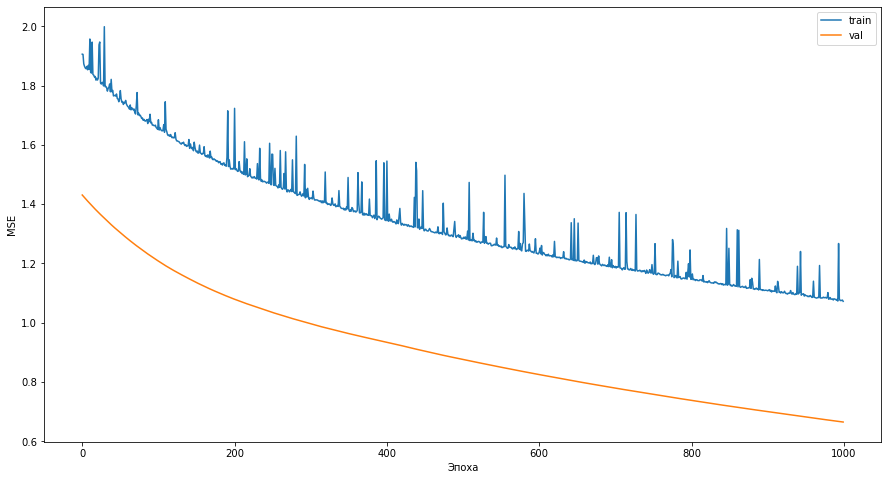

In [20]:
import seaborn as sns
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"Эпоха", "value": "MSE", "variable": ""})
plt.figure(figsize=(15,8))
plot = sns.lineplot(data=train_val_loss_df, x="Эпоха", y="MSE", hue="")

Применение нейронной сети позволяет уменьшить ошибку до 0.66526. Кроме того, качество нейронной сети может быть улучшено при помощи увеличения количества эпох.